# Character-level recurrent sequence-to-sequence model
Author: [fchollet](https://twitter.com/fchollet)

Date created: 2017/09/29

Last modified: 2020/04/26

Description: Character-level recurrent sequence-to-sequence model.

Small additions by Pierre Nugues.

You will have to run and complete two notebooks. This is the second one.

## Introduction
This example demonstrates how to implement a basic character-level
recurrent sequence-to-sequence model. We apply it to translating
short English sentences into short French sentences,
character-by-character. Note that it is fairly unusual to
do character-level machine translation, as word-level
models are more common in this domain.
**Summary of the algorithm**
- We start with input sequences from a domain (e.g. English sentences)
    and corresponding target sequences from another domain
    (e.g. French sentences).
- An encoder LSTM turns input sequences to 2 state vectors
    (we keep the last LSTM state and discard the outputs).
- A decoder LSTM is trained to turn the target sequences into
    the same sequence but offset by one timestep in the future,
    a training process called "teacher forcing" in this context.
    It uses as initial state the state vectors from the encoder.
    Effectively, the decoder learns to generate `targets[t+1...]`
    given `targets[...t]`, conditioned on the input sequence.
- In inference mode, when we want to decode unknown input sequences, we:
    - Encode the input sequence into state vectors
    - Start with a target sequence of size 1
        (just the start-of-sequence character)
    - Feed the state vectors and 1-char target sequence
        to the decoder to produce predictions for the next character
    - Sample the next character using these predictions
        (we simply use argmax).
    - Append the sampled character to the target sequence
    - Repeat until we generate the end-of-sequence character or we
        hit the character limit.

## Setup

In [29]:
import random
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras import layers 
import matplotlib.pyplot as plt

In [2]:
random.seed(1234)
np.random.seed(1234)
tf.random.set_seed(1234)

## Download the data

Have a look at the http://www.manythings.org/anki/ site and select a corpus with at least 10,000 pairs. You should understand the target language well. Ideally, it should be your mother tongue.
Then uncomment and run the lines below.

In [3]:
#!curl -O http://www.manythings.org/anki/fra-eng.zip
#!unzip fra-eng.zip

## Configuration

Run this notebook on Google Colab if you do not have a GPU. You will need then to mount the Google drive and configure the path. The cells below will help you.

You have to choose between a local execution on `my_machine` and `colab`

In [3]:
# The machine name
machine_name = 'my_machine' # 'colab' # or 'my_machine'

In [4]:
if machine_name == 'colab':
    from google.colab import drive
    drive.mount("/content/drive")

Adapt the path to your configuration

In [5]:
# Path to the data txt file on disk.
if machine_name == 'colab':
    data_path = '/content/drive/My Drive/Colab Notebooks/traduction LSTM/fra.txt'
else:
    data_path = '/Users/filippahansen/Desktop/Språkteknologi/ilppp/programs/corpus/swe-eng/swe.txt'

In [164]:
batch_size = 64  # Batch size for training.
epochs = 100  # Number of epochs to train for.
latent_dim = 256  # Latent dimensionality of the encoding space.
num_samples = 10000  # Number of samples to train on.

## Prepare the data

Run the next cells to prepare the dataset. Be sure you understand all the code. I printed intermediate outputs to help you.

### Creating the pairs

In [7]:
# Vectorize the data.
input_texts = []
target_texts = []
input_characters = set()
target_characters = set()
with open(data_path, "r", encoding="utf-8") as f:
    lines = f.read().split("\n")

In [8]:
for line in lines[: min(num_samples, len(lines) - 1)]:
    input_text, target_text, _ = line.split("\t")
    # We use "tab" as the "start sequence" character
    # for the targets, and "\n" as "end sequence" character.
    target_text = "\t" + target_text + "\n"
    input_texts.append(input_text)
    target_texts.append(target_text)
    for char in input_text:
        if char not in input_characters:
            input_characters.add(char)
    for char in target_text:
        if char not in target_characters:
            target_characters.add(char)

In [9]:
input_texts[1000]

'I have a kid.'

In [10]:
target_texts[1000]

'\tJag har ett barn.\n'

### The input and output symbols

In [11]:
input_characters = sorted(list(input_characters))
print(input_characters)

[' ', '!', '"', "'", ',', '-', '.', '0', '1', '2', '5', '6', '7', '9', ':', '?', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'R', 'S', 'T', 'U', 'V', 'W', 'Y', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '€']


In [12]:
target_characters = sorted(list(target_characters))
print(target_characters)

['\t', '\n', ' ', '!', ',', '-', '.', '0', '1', '2', '5', '6', '7', '9', ':', '?', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'R', 'S', 'T', 'U', 'V', 'W', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', 'Ä', 'Å', 'Ö', 'à', 'ä', 'å', 'é', 'ö', '”']


In [13]:
num_encoder_tokens = len(input_characters)
num_decoder_tokens = len(target_characters)
max_encoder_seq_length = max([len(txt) for txt in input_texts])
max_decoder_seq_length = max([len(txt) for txt in target_texts])

In [14]:
print("Number of samples:", len(input_texts))
print("Number of unique input tokens:", num_encoder_tokens)
print("Number of unique output tokens:", num_decoder_tokens)
print("Max sequence length for inputs:", max_encoder_seq_length)
print("Max sequence length for outputs:", max_decoder_seq_length)

Number of samples: 10000
Number of unique input tokens: 66
Number of unique output tokens: 73
Max sequence length for inputs: 21
Max sequence length for outputs: 46


### Creating the indices

In [15]:
input_token_index = dict([(char, i) for i, char in enumerate(input_characters)])
target_token_index = dict([(char, i) for i, char in enumerate(target_characters)])

In [16]:
input_token_index

{' ': 0,
 '!': 1,
 '"': 2,
 "'": 3,
 ',': 4,
 '-': 5,
 '.': 6,
 '0': 7,
 '1': 8,
 '2': 9,
 '5': 10,
 '6': 11,
 '7': 12,
 '9': 13,
 ':': 14,
 '?': 15,
 'A': 16,
 'B': 17,
 'C': 18,
 'D': 19,
 'E': 20,
 'F': 21,
 'G': 22,
 'H': 23,
 'I': 24,
 'J': 25,
 'K': 26,
 'L': 27,
 'M': 28,
 'N': 29,
 'O': 30,
 'P': 31,
 'R': 32,
 'S': 33,
 'T': 34,
 'U': 35,
 'V': 36,
 'W': 37,
 'Y': 38,
 'a': 39,
 'b': 40,
 'c': 41,
 'd': 42,
 'e': 43,
 'f': 44,
 'g': 45,
 'h': 46,
 'i': 47,
 'j': 48,
 'k': 49,
 'l': 50,
 'm': 51,
 'n': 52,
 'o': 53,
 'p': 54,
 'q': 55,
 'r': 56,
 's': 57,
 't': 58,
 'u': 59,
 'v': 60,
 'w': 61,
 'x': 62,
 'y': 63,
 'z': 64,
 '€': 65}

In [17]:
target_token_index

{'\t': 0,
 '\n': 1,
 ' ': 2,
 '!': 3,
 ',': 4,
 '-': 5,
 '.': 6,
 '0': 7,
 '1': 8,
 '2': 9,
 '5': 10,
 '6': 11,
 '7': 12,
 '9': 13,
 ':': 14,
 '?': 15,
 'A': 16,
 'B': 17,
 'C': 18,
 'D': 19,
 'E': 20,
 'F': 21,
 'G': 22,
 'H': 23,
 'I': 24,
 'J': 25,
 'K': 26,
 'L': 27,
 'M': 28,
 'N': 29,
 'O': 30,
 'P': 31,
 'R': 32,
 'S': 33,
 'T': 34,
 'U': 35,
 'V': 36,
 'W': 37,
 'a': 38,
 'b': 39,
 'c': 40,
 'd': 41,
 'e': 42,
 'f': 43,
 'g': 44,
 'h': 45,
 'i': 46,
 'j': 47,
 'k': 48,
 'l': 49,
 'm': 50,
 'n': 51,
 'o': 52,
 'p': 53,
 'q': 54,
 'r': 55,
 's': 56,
 't': 57,
 'u': 58,
 'v': 59,
 'w': 60,
 'x': 61,
 'y': 62,
 'z': 63,
 'Ä': 64,
 'Å': 65,
 'Ö': 66,
 'à': 67,
 'ä': 68,
 'å': 69,
 'é': 70,
 'ö': 71,
 '”': 72}

### Vectorizing
We use one-hot encoding

In [18]:
encoder_input_data = np.zeros(
    (len(input_texts), max_encoder_seq_length, num_encoder_tokens), dtype="float32"
)
decoder_input_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens), dtype="float32"
)
decoder_target_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens), dtype="float32"
)
decoder_target_data

array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       ...,

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0.

In [20]:
input_texts[0]

'Go.'

In [19]:
target_texts[0]

'\tGå.\n'

Be sure to undesrtand how the arrays `decoder_input_data` and `decoder_target_data` are structured. In your report, you will explain it. You will give an example.

In [21]:
for i, (input_text, target_text) in enumerate(zip(input_texts, target_texts)):
    for t, char in enumerate(input_text):
        encoder_input_data[i, t, input_token_index[char]] = 1.0
    encoder_input_data[i, t + 1 :, input_token_index[" "]] = 1.0
    for t, char in enumerate(target_text):
        # decoder_target_data is ahead of decoder_input_data by one timestep
        decoder_input_data[i, t, target_token_index[char]] = 1.0
        if t > 0:
            # decoder_target_data will be ahead by one timestep
            # and will not include the start character.
            decoder_target_data[i, t - 1, target_token_index[char]] = 1.0
    decoder_input_data[i, t + 1 :, target_token_index[" "]] = 1.0
    decoder_target_data[i, t:, target_token_index[" "]] = 1.0

### Understanding the vectorization

In [22]:
encoder_input_data[0]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [257]:
input_token_index['G']

22

In [253]:
encoder_input_data[0][5]

array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
      dtype=float32)

In [254]:
len(encoder_input_data[0][5])

66

In [25]:
decoder_input_data[0]

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.]], dtype=float32)

In [26]:
target_token_index['V']

36

In [27]:
decoder_input_data[0][:5]

array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 1., 0., 0., 0.],
 

In [28]:
decoder_target_data[0][:5]

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0.],
 

## Build the model

Write an encoder with two LSTM layers. Name these two layers `encoder_lstm_1` and `encoder_lstm_2`. Start from the initial code and modify it. Add a dropout and a recurrent dropout. Read the documentation here: https://keras.io/api/layers/recurrent_layers/lstm/

In [30]:
# Define an input sequence and process it.
# encoder_inputs = keras.Input(shape=(None, num_encoder_tokens), name='encoder_input')
# encoder = keras.layers.LSTM(latent_dim, return_state=True, name='encoder_lstm')
# encoder_outputs, state_h, state_c = encoder(encoder_inputs)

In [157]:
# Write your code
encoder_inputs = keras.Input(shape=(None, num_encoder_tokens), name='encoder_input')
encoder_lstm_1 = keras.layers.LSTM(latent_dim, return_state=True,return_sequences=True, name='encoder_lstm_1')
encoder_lstm_2 = keras.layers.LSTM(latent_dim, return_state=True, return_sequences=True,dropout=0.2, recurrent_dropout=0.2, name='encoder_lstm_2')

encoder_outputs_1, state_h0, state_c0 = encoder_lstm_1(encoder_inputs)
encoder_states_0 = [state_h0, state_c0]
encoder_outputs, state_h, state_c = encoder_lstm_2(encoder_outputs_1, initial_state=encoder_states_0    ) # h_last - hidden states, c_last - lstm cell state

In [158]:
## testing

test_model = keras.Model(inputs=encoder_inputs, outputs=[encoder_outputs]) # change something in encoder putputs???
test_model.summary()

Model: "model_19"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      [(None, None, 66)]   0                                            
__________________________________________________________________________________________________
encoder_lstm_1 (LSTM)           [(None, None, 256),  330752      encoder_input[0][0]              
__________________________________________________________________________________________________
encoder_lstm_2 (LSTM)           [(None, None, 256),  525312      encoder_lstm_1[0][0]             
                                                                 encoder_lstm_1[0][1]             
                                                                 encoder_lstm_1[0][2]             
Total params: 856,064
Trainable params: 856,064
Non-trainable params: 0
___________________

In [159]:
# We discard `encoder_outputs` and only keep the states.
encoder_states = [state_h, state_c]

In [160]:
# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = keras.Input(shape=(None, num_decoder_tokens), name='decoder_input')

In [167]:
# We set up our decoder to return full output sequences,
# and to return internal states as well. We don't use the
# return states in the training model, but we will use them in inference.
decoder_lstm = keras.layers.LSTM(latent_dim, return_sequences=True, return_state=True, dropout=0.2, recurrent_dropout=0.2, name='decoder_lstm')
decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=encoder_states)
decoder_dense = keras.layers.Dense(num_decoder_tokens, activation="softmax", name='decoder_dense')
decoder_outputs = decoder_dense(decoder_outputs)

In [168]:
# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model = keras.Model([encoder_inputs, decoder_inputs], decoder_outputs)

## Train the model

In [169]:
model.compile(
    optimizer="rmsprop", loss="categorical_crossentropy", metrics=["accuracy"]
)

In [170]:
callback_list = [
    keras.callbacks.EarlyStopping(monitor='val_loss', patience=5),
    keras.callbacks.ModelCheckpoint(filepath='2lstm_2do.keras', monitor='val_loss', save_best_only=True)
]

In [171]:
history = model.fit( #TODO 1
    [encoder_input_data, decoder_input_data],
    decoder_target_data,
    batch_size=batch_size,
    epochs=epochs,
    validation_split=0.2,
    callbacks=callback_list
)

Epoch 1/100
125/125 [==============================] - 48s 350ms/step - loss: 1.4691 - accuracy: 0.6514 - val_loss: 1.4109 - val_accuracy: 0.6074
Epoch 2/100
125/125 [==============================] - 45s 357ms/step - loss: 1.0451 - accuracy: 0.7156 - val_loss: 1.1309 - val_accuracy: 0.6762
Epoch 3/100
125/125 [==============================] - 46s 369ms/step - loss: 0.8712 - accuracy: 0.7534 - val_loss: 1.0034 - val_accuracy: 0.7078
Epoch 4/100
125/125 [==============================] - 43s 347ms/step - loss: 0.7922 - accuracy: 0.7732 - val_loss: 0.9634 - val_accuracy: 0.7190
Epoch 5/100
125/125 [==============================] - 44s 355ms/step - loss: 0.7436 - accuracy: 0.7857 - val_loss: 0.8905 - val_accuracy: 0.7405
Epoch 6/100
125/125 [==============================] - 40s 322ms/step - loss: 0.7057 - accuracy: 0.7951 - val_loss: 0.8564 - val_accuracy: 0.7486
Epoch 7/100
125/125 [==============================] - 47s 377ms/step - loss: 0.6761 - accuracy: 0.8036 - val_loss: 0.8283 -

In [172]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

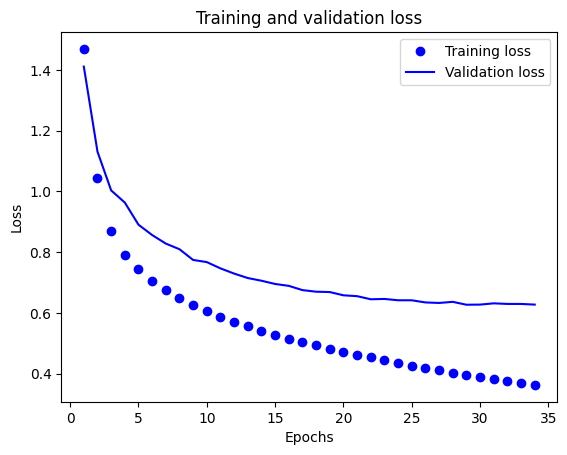

In [173]:
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

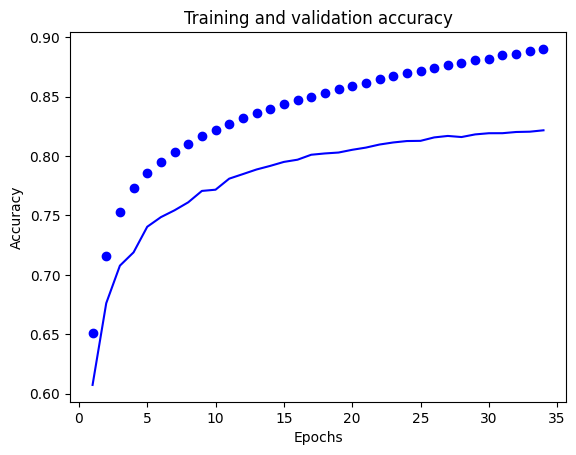

In [174]:
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

In [42]:
# Save model
#model.save("s5s")

## Run inference (sampling)
1. encode input and retrieve initial decoder state
2. run one step of decoder with this initial state
and a "start of sequence" token as target.
Output will be the next target token.
3. Repeat with the current target token and current states

In [43]:
# Define sampling models
# Restore the model and construct the encoder and decoder.
# model = keras.models.load_model('2lstm_2do.keras')

In [179]:
model.summary()

Model: "model_22"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      [(None, None, 66)]   0                                            
__________________________________________________________________________________________________
encoder_lstm_1 (LSTM)           [(None, None, 256),  330752      encoder_input[0][0]              
__________________________________________________________________________________________________
decoder_input (InputLayer)      [(None, None, 73)]   0                                            
__________________________________________________________________________________________________
encoder_lstm_2 (LSTM)           [(None, None, 256),  525312      encoder_lstm_1[0][0]             
                                                                 encoder_lstm_1[0][1]      

In [176]:
model.layers

In [177]:
[model_layer.name for model_layer in model.layers]

['encoder_input',
 'encoder_lstm_1',
 'decoder_input',
 'encoder_lstm_2',
 'decoder_lstm',
 'decoder_dense']

In [180]:
model.input

[<KerasTensor: shape=(None, None, 66) dtype=float32 (created by layer 'encoder_input')>,
 <KerasTensor: shape=(None, None, 73) dtype=float32 (created by layer 'decoder_input')>]

You will now connect the outputs of the encoder. You will start from the initial notebook and modify one line so that you match the layers. Draw a picture to understand your model

In [110]:
"""
# Initial code
encoder_inputs = model.input[0]  # input_1
encoder_outputs, state_h_enc, state_c_enc = model.layers[2].output  # lstm_1
encoder_states = [state_h_enc, state_c_enc]
encoder_model = keras.Model(encoder_inputs, encoder_states)
"""

'\n# Initial code\nencoder_inputs = model.input[0]  # input_1\nencoder_outputs, state_h_enc, state_c_enc = model.layers[2].output  # lstm_1\nencoder_states = [state_h_enc, state_c_enc]\nencoder_model = keras.Model(encoder_inputs, encoder_states)\n'

In [184]:
# Write your code here
encoder_inputs = model.input[0]  # input_1
encoder_outputs, state_h_enc, state_c_enc = model.layers[3].output  # lstm_1 er
encoder_states = [state_h_enc, state_c_enc]
encoder_model = keras.Model(encoder_inputs, encoder_states)


Starting from the initial code, you will now connect the model layers to the decoder.

In [50]:
"""
# Initial code
decoder_inputs = model.input[1]  # input_2
decoder_state_input_h = keras.Input(shape=(latent_dim,))
decoder_state_input_c = keras.Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_lstm = model.layers[3]
decoder_outputs, state_h_dec, state_c_dec = decoder_lstm(
    decoder_inputs, initial_state=decoder_states_inputs
)
decoder_states = [state_h_dec, state_c_dec]
decoder_dense = model.layers[4]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = keras.Model(
    [decoder_inputs] + decoder_states_inputs, [decoder_outputs] + decoder_states
)
"""

'\n# Initial code\ndecoder_inputs = model.input[1]  # input_2\ndecoder_state_input_h = keras.Input(shape=(latent_dim,))\ndecoder_state_input_c = keras.Input(shape=(latent_dim,))\ndecoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]\ndecoder_lstm = model.layers[3]\ndecoder_outputs, state_h_dec, state_c_dec = decoder_lstm(\n    decoder_inputs, initial_state=decoder_states_inputs\n)\ndecoder_states = [state_h_dec, state_c_dec]\ndecoder_dense = model.layers[4]\ndecoder_outputs = decoder_dense(decoder_outputs)\ndecoder_model = keras.Model(\n    [decoder_inputs] + decoder_states_inputs, [decoder_outputs] + decoder_states\n)\n'

In [185]:
# Write your code
decoder_inputs = model.input[1]  # input_2
decoder_state_input_h = keras.Input(shape=(latent_dim,))
decoder_state_input_c = keras.Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

decoder_lstm = model.layers[4] # at index 4
decoder_outputs, state_h_dec, state_c_dec = decoder_lstm(
    decoder_inputs, initial_state=decoder_states_inputs
)
decoder_states = [state_h_dec, state_c_dec]
decoder_dense = model.layers[5] # at index 5
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = keras.Model(
    [decoder_inputs] + decoder_states_inputs, [decoder_outputs] + decoder_states
)

In [186]:
# Reverse-lookup token index to decode sequences back to
# something readable.
reverse_input_char_index = dict((i, char) for char, i in input_token_index.items())
reverse_target_char_index = dict((i, char) for char, i in target_token_index.items())

In [187]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1, num_decoder_tokens))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0, target_token_index["\t"]] = 1.0

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ""
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value, verbose=False)

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_char_index[sampled_token_index]
        decoded_sentence += sampled_char

        # Exit condition: either hit max length
        # or find stop character.
        if sampled_char == "\n" or len(decoded_sentence) > max_decoder_seq_length:
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1, num_decoder_tokens))
        target_seq[0, 0, sampled_token_index] = 1.0

        # Update states
        states_value = [h, c]
    return decoded_sentence

You can now generate decoded sentences as such:

In [215]:
for seq_index in range(20):
    # Take one sequence (part of the training set)
    # for trying out decoding.
    input_seq = encoder_input_data[seq_index : seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)
    print(input_seq)
    print("-")
    print("Input sentence:", input_texts[seq_index])
    print("Decoded sentence:", decoded_sentence)

[[[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [1. 0. 0. ... 0. 0. 0.]
  [1. 0. 0. ... 0. 0. 0.]
  [1. 0. 0. ... 0. 0. 0.]]]
-
Input sentence: Go.
Decoded sentence: Gå.

[[[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [1. 0. 0. ... 0. 0. 0.]
  [1. 0. 0. ... 0. 0. 0.]
  [1. 0. 0. ... 0. 0. 0.]]]
-
Input sentence: Run!
Decoded sentence: Spring!

[[[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [1. 0. 0. ... 0. 0. 0.]
  [1. 0. 0. ... 0. 0. 0.]
  [1. 0. 0. ... 0. 0. 0.]]]
-
Input sentence: Who?
Decoded sentence: Vem?

[[[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [1. 0. 0. ... 0. 0. 0.]
  [1. 0. 0. ... 0. 0. 0.]
  [1. 0. 0. ... 0. 0. 0.]]]
-
Input sentence: Help!
Decoded sentence: Hjälp!

[[[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [1. 0. 0. ... 0. 0. 0.]
  [1. 0. 0. ... 0. 0. 0.]
  [1. 0. 0. ... 

Write a `translate()` function that takes a string as argument and returns its translation 

In [ ]:
# 1. find index for each word, Create a one-hot vector for the input text - do this for each word!
# 
# the one-hot vector must correspond to the one for the word in encoder_model
# 2. translated_word = decode_sequence(one_hot_vector) - append the translated words 

In [237]:
# Write your code
def translate(input_text):
    input_seq = np.zeros((1, max_encoder_seq_length, num_encoder_tokens), dtype="float32")
    for t, char in enumerate(input_text):
        input_seq[0, t, input_token_index[char]] = 1.0
    input_seq[0, t + 1 :, input_token_index[" "]] = 1.0
    translated = decode_sequence(input_seq)
    return translated


In [269]:
translation = translate('It seems that way')
print(translation)

Det måste vara det.

